In [1]:
import torch
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import  torch.nn as nn
import  torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader
import  numpy as np
import  matplotlib.pyplot as plt
import  seaborn as sns
import  pandas as pd
import torchvision.transforms as transforms
from PIL import Image
from torchvision.models import  ResNet50_Weights

from torch.utils.data import Dataset
import os

epochs_num=20
seed=33
device='cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE=128
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

%matplotlib inline


In [2]:
train_ids = ["1", "3", "6", "7", "10", "13", "15", "16", "18", "22", "23", "31",
             "32", "36", "38", "39", "40", "41", "42", "48", "50", "52", "53", "54"]

val_ids = ["0", "2", "8", "12", "17", "19", "24", "26", "27", "28", "30", "33", "46", "49", "51"]

In [3]:

def prepare_model(image_level=True):
    if image_level:
        preprocess=transforms.Compose([transforms.Resize((256,256)),
                                       transforms.CenterCrop((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                       ])
    else:
        preprocess=transforms.Compose([transforms.Resize((256,256)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                       ])

    model=models.resnet50(weights=ResNet50_Weights)
    in_features = model.fc.in_features
    print(in_features)

    model.fc=nn.Linear(in_features,8)
    
    for param in model.parameters():
        param.requires_grad=False
        
    for param in model.layer3.parameters():
        param.requires_grad = True
        
    for param in model.layer4.parameters():
        param.requires_grad = True
    
    for param in model.fc.parameters():
        param.requires_grad = True
        




    model.to(device)

    return model,preprocess

In [4]:

def load_players_data(annotation_path):
    with open(annotation_path,'r') as f:
        player_boxes={idx:[] for idx in range(12)}
        frame_boxes_dct={}
        for idx,line in enumerate(f):
            box_info=BoxInfo(line)
            if box_info.player_id>11:
                continue
            player_boxes[box_info.player_id].append(box_info)
        for player_id,boxes_info in player_boxes.items():

            boxes_info=boxes_info[5:]
            boxes_info=boxes_info[:-6]

            for box_info in boxes_info:

                if box_info.frame_id not in frame_boxes_dct:
                    frame_boxes_dct[box_info.frame_id]=[]
                frame_boxes_dct[box_info.frame_id].append(box_info)
        return  frame_boxes_dct

def load_video_annotation(path):
    with open(path,'r')as f:
        clip_cat={}
        for line in f:
            items=line.strip().split(' ')[:2]
            clip_dir=items[0].replace('.jpg','')
            clip_cat[clip_dir]=items[1]
        return  clip_cat

def load_volley_ball_dataset(videos_root,annotation_root):
    videos_dir=os.listdir(videos_root)
    videos_dir.sort()
    videos_annotation={}

    for idx,video_dir in enumerate(videos_dir):
        video_dir_path=os.path.join(videos_root,video_dir)
        if not os.path.isdir(video_dir_path):
            continue
        video_annotation=os.path.join(video_dir_path,'annotations.txt')
        clip_category_dict=load_video_annotation(video_annotation)
        clips_dir=os.listdir(video_dir_path)
        clips_dir.sort()
        clip_annotation={}
        for clip_dir in clips_dir:
            clip_dir_path=os.path.join(video_dir_path,clip_dir)
            if not os.path.isdir(clip_dir_path):
                continue
            annot_file=os.path.join(annotation_root,video_dir,clip_dir,f'{clip_dir}.txt')
            frame_boxes_dct=load_players_data(annot_file)
            clip_annotation[clip_dir]={
                'category':clip_category_dict[clip_dir],
                'frame_boxes_dct':frame_boxes_dct
            }
        videos_annotation[video_dir]=clip_annotation
    return videos_annotation


In [5]:
class BoxInfo():
    def __init__(self,line):
        words=line.split()
        self.category=words.pop()
        words=[int (string) for string in words]
        self.player_id=words[0]
        del words[0]

        x1,y1,x2,y2,frame_id,lost,grouping,generated=words
        self.box=x1,y1,x2,y2
        self.frame_id=frame_id
        self.lost=lost
        self.grouping=grouping
        self.generated=generated

In [6]:
class Volly_b1(Dataset):
    def __init__(self,dataset,videos_path,indices,transform=None):
        self.dataset=dataset
        self.videos_path=videos_path
        self.indices=indices
        self.dataset={key:value for key ,value in dataset.items() if key in self.indices}
        self.transform=transform

        self.indices=[(video_index, clip_id, frame_id,clip['category']) for video_index in self.dataset.keys()
                        for clip_id,clip in self.dataset[video_index].items()
                        for frame_id in self.dataset[video_index][clip_id]['frame_boxes_dct'].keys()]

        self.classes = set(clip['category'] for video_index in self.dataset.keys() for clip_id, clip in
                           self.dataset[video_index].items())
        self.classes=sorted(self.classes)
        self.class_to_index={clip_class:idx for idx,clip_class in enumerate (self.classes)}



    def __to_df__(self):
        indices=self.indices
        self.df=pd.DataFrame(indices,columns=['Video','Frame_id','Clip_id','Category'])
        # self.df['Category']=self.df['Category'].map(self.class_to_index)
        # print(self.df)
        return self.df




    def __len__ (self):
            return len(self.indices)

    def __getitem__ (self, idx):
            # Get the (video_index, clip_id, frame_id,category) tuple for the given index
            video_index, clip_id, frame_id,category = self.indices[idx]

            # Get the class of the clip (label) and map to an integer index
            clip_class = category
            clip_class_idx = self.class_to_index[clip_class]

            # Convert clip_class to a tensor
            # clip_class_idx = torch.tensor(clip_class_idx, dtype=torch.long)

            # Construct the path to the frame image
            frame_path = os.path.join(self.videos_path, video_index, clip_id, f"{frame_id}.jpg")

            # Load the frame image
            frame = Image.open(frame_path)

            if self.transform:
                frame = self.transform(frame)

            # Return the frame image and its integer class label
            return frame, clip_class_idx

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s]


2048
  Video Frame_id  Clip_id Category
0     0    13286    13281    r_set
1     0    13286    13282    r_set
2     0    13286    13283    r_set
3     0    13286    13284    r_set
4     0    13286    13285    r_set


<Axes: xlabel='Category'>

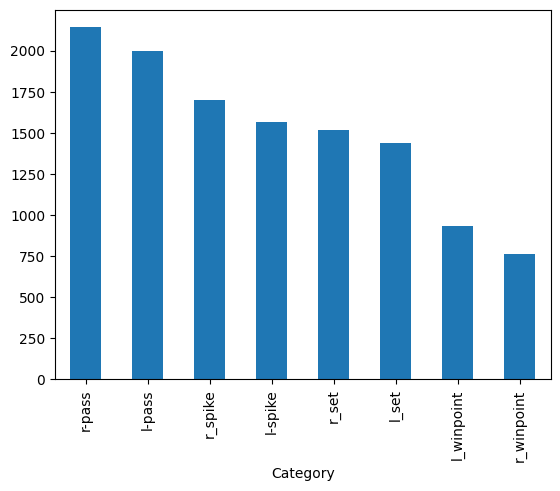

In [7]:
    dataset_root = '/kaggle/input/volleyball'
    model,preprocess=prepare_model(image_level=True)
    
    videos_root=f'{dataset_root}/volleyball_/videos'
    annotation_root=f'{dataset_root}/volleyball_tracking_annotation/volleyball_tracking_annotation'
    dataset=load_volley_ball_dataset(videos_root,annotation_root)

    train_dataset=Volly_b1(dataset,videos_root,train_ids,transform=preprocess)
    val_dataset=Volly_b1(dataset,videos_root,val_ids,transform=preprocess)
    val_df=Volly_b1(dataset,videos_root,val_ids,transform=preprocess).__to_df__()
    print(val_df.head())
    val_df['Category'].value_counts().plot.bar()

In [8]:
train_loader=DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader=DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=False)
crieterion=nn.CrossEntropyLoss()
print(len(train_loader))
optimizer=optim.AdamW(model.parameters(),lr=0.001)

152


In [9]:
def train(model,dataloader,optimizer,criterion,device,epochs):
    model.train()
    for epoch in range(epochs):
        total_loss=0
        avg_loss=[]

        correct=0
        total=0
        for input,label in dataloader:
            input,label=input.to(device),label.to(device)
            optimizer.zero_grad()

            outputs=model(input)
            batch_loss=criterion(outputs,label)

            batch_loss.backward()
            optimizer.step()
            total_loss+=batch_loss.item()

            _,predicted=torch.max(outputs,1)
            correct+=(predicted == label).sum().item()
            total+=label.size(0)
        epoch_loss=total_loss/len(dataloader)
        epoch_acc=100*correct/total
        print(f'Epoch {epoch+1}/{epochs},Loss: {epoch_loss:.4f}, Accuracy_per_epoch: {epoch_acc:.2f}%')
        avg_loss.append(epoch_loss)
def eval_model(model,dataloader,device):
    all_pred=[]
    all_labels=[]
    total=0
    correct=0

    model.eval()

    with torch.no_grad():
        for input,label in dataloader:
            input, label = input.to(device), label.to(device)
            preds = model(input)

            preds=torch.argmax(preds,dim=1).cpu().numpy()
            label=label.cpu().numpy()
            all_pred.extend(preds)
            all_labels.extend(label)
        all_pred = np.array(all_pred)
        all_labels = np.array(all_labels)

        accuracy=accuracy_score(all_labels,all_pred)
        cm=confusion_matrix(all_labels,all_pred)
        report_val=classification_report(all_labels,all_pred,zero_division=0)
    return  cm,report_val,accuracy


Epoch 1/20,Loss: 0.5930, Accuracy_per_epoch: 78.54%
Epoch 2/20,Loss: 0.1705, Accuracy_per_epoch: 94.35%
Epoch 3/20,Loss: 0.0755, Accuracy_per_epoch: 97.66%
Epoch 4/20,Loss: 0.0405, Accuracy_per_epoch: 98.71%
Epoch 5/20,Loss: 0.0360, Accuracy_per_epoch: 99.01%
Epoch 6/20,Loss: 0.0272, Accuracy_per_epoch: 99.28%
Epoch 7/20,Loss: 0.0482, Accuracy_per_epoch: 98.53%
Epoch 8/20,Loss: 0.0327, Accuracy_per_epoch: 99.00%
Epoch 9/20,Loss: 0.0217, Accuracy_per_epoch: 99.36%
Epoch 10/20,Loss: 0.0102, Accuracy_per_epoch: 99.72%
Epoch 11/20,Loss: 0.0140, Accuracy_per_epoch: 99.57%
Epoch 12/20,Loss: 0.0254, Accuracy_per_epoch: 99.26%
Epoch 13/20,Loss: 0.0370, Accuracy_per_epoch: 98.83%
Epoch 14/20,Loss: 0.0362, Accuracy_per_epoch: 98.83%
Epoch 15/20,Loss: 0.0193, Accuracy_per_epoch: 99.45%
Epoch 16/20,Loss: 0.0096, Accuracy_per_epoch: 99.74%
Epoch 17/20,Loss: 0.0142, Accuracy_per_epoch: 99.55%
Epoch 18/20,Loss: 0.0173, Accuracy_per_epoch: 99.48%
Epoch 19/20,Loss: 0.0115, Accuracy_per_epoch: 99.59%
Ep

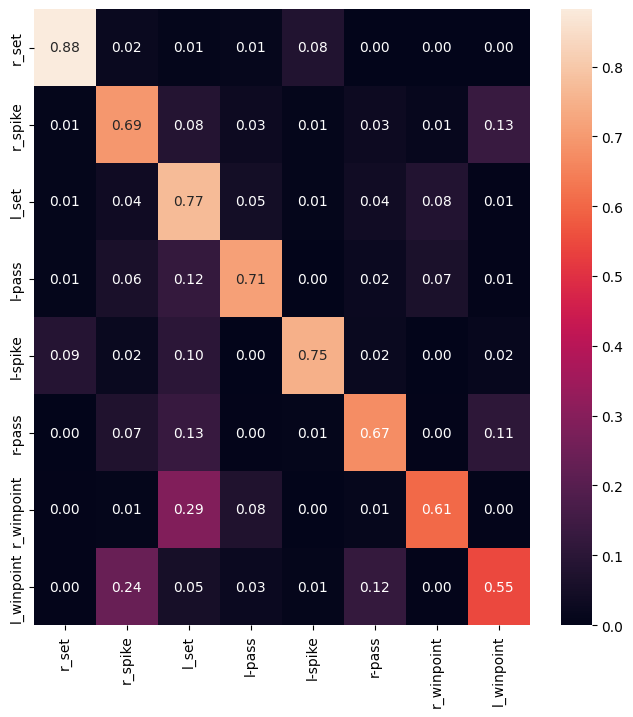

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       936
           1       0.68      0.69      0.69      2142
           2       0.57      0.77      0.65      1998
           3       0.78      0.71      0.74      1566
           4       0.81      0.75      0.77       765
           5       0.74      0.67      0.70      1701
           6       0.74      0.61      0.67      1440
           7       0.62      0.55      0.58      1521

    accuracy                           0.70     12069
   macro avg       0.72      0.70      0.71     12069
weighted avg       0.70      0.70      0.70     12069

acuracy:0.6951694423730218


In [10]:
    train(model,train_loader,optimizer,crieterion,device,epochs=epochs_num)
    cm,report_val,accuracy=eval_model(model,val_loader,device)
    classes=val_df['Category'].unique()
    plt.figure(figsize=(8,8))
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes)
    plt.show()
    
    print(report_val)

    print(f"acuracy:{accuracy}")
